In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import re
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Data from CSV

In [ ]:
data = pd.read_csv('news_articles.csv')
data.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


Cleaning the Data

In [ ]:
# checking for null values
data.isnull().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

In [ ]:
# removing all the null rows
data = data.dropna(how='any',axis=0)

In [ ]:
data['type'].unique()

array(['bias', 'conspiracy', 'fake', 'bs', 'satire', 'hate', 'junksci',
       'state'], dtype=object)

# Analysing the Data set
## Checking how the different attributes affect the news being fake or real

We first check for the 'Type' of news we are taking into consideration

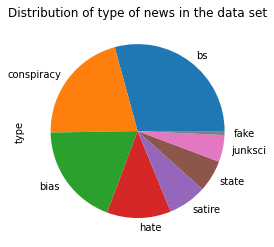

In [ ]:
data['type'].value_counts().plot.pie()
plt.title('Distribution of type of news in the data set')
plt.show()

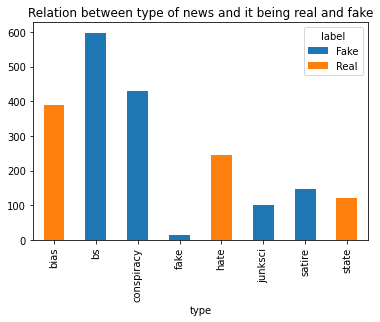

In [ ]:
ct = pd.crosstab(data['type'], data['label'])
ct.plot(kind='bar', stacked=True)
plt.title('Relation between type of news and it being real and fake')
plt.show()

Checking for the websites the news was published

In [ ]:
websites_real_news = []
websites_fake_news = []

for index, row in data.iterrows():
    if(row['label'] == 'Real'):
        websites_real_news.append(row['site_url'])
    elif(row['label'] == 'Fake'):
        websites_fake_news.append(row['site_url'])

In [ ]:
print('Websites that print fake news : ', set(websites_fake_news))
print()
print('Websites that print real news : ', set(websites_real_news))

Websites that print fake news :  {'theeconomiccollapseblog.com', 'awdnews.com', 'amren.com', 'shiftfrequency.com', 'theonion.com', 'abcnews.com.co', 'presstv.ir', 'thetruthseeker.co.uk', 'counterpunch.org', 'dcclothesline.com', 'naturalnews.com', 'thedailysheeple.com', 'prisonplanet.com', 'countercurrents.org', 'intrepidreport.com', 'galacticconnection.com', 'madworldnews.com', 'westernjournalism.com', 'abovetopsecret.com', 'davidwolfe.com', 'activistpost.com', 'americannews.com', 'barenakedislam.com', 'whatreallyhappened.com', 'veteranstoday.com', 'returnofkings.com', 'americasfreedomfighters.com', 'thefreethoughtproject.com', 'thesaker.is', 'theunrealtimes.com', 'clickhole.com', 'abeldanger.net', 'frontpagemag.com', 'thepeoplescube.com', 'fromthetrenchesworldreport.com', 'allnewspipeline.com', 'darkmoon.me', '21stcenturywire.com', 'adobochronicles.com', 'amtvmedia.com', 'infowars.com', 'departed.co', 'globalresearch.ca', 'projectveritas.com', 'washingtonsblog.com', 'ahtribune.com', '

In [ ]:
fake_and_real = list(set(websites_fake_news) & set(websites_real_news))
print('Websites that print both fake and real news : ', fake_and_real)

Websites that print both fake and real news :  ['fromthetrenchesworldreport.com', 'newstarget.com', 'presstv.ir', 'washingtonsblog.com', 'prisonplanet.com', 'returnofkings.com', 'davidduke.com', 'westernjournalism.com', 'frontpagemag.com']


We then breakdown and check for the authors on this websites who write fake news

In [ ]:
author_fake = []
author_real = []

frames = []
for site in fake_and_real:
    d = data.loc[data['site_url'] == site]
    frames.append(d)
    
temp = pd.concat(frames)

for i,row in temp.iterrows():
    key = row['site_url']
    value = row['author']
    if(row['label'] == 'Real'):
        author_real.append((key,value))

    elif(row['label'] == 'Fake'):
        author_fake.append((key,value))

In [ ]:
author_fake = list(set(author_fake))
author_real = list(set(author_real))
print('Number of Authors that write real news : ' , len(author_real))
print('Number of Authors that write fake news : ' , len(author_fake))

Number of Authors that write real news :  168
Number of Authors that write fake news :  36


Checking for the different languages so that we can use those stop words

In [ ]:
data['language'].value_counts()

english    1967
german       72
ignore        3
french        2
spanish       1
Name: language, dtype: int64

In [ ]:
stpwords = []
languages = data['language'].unique()
languages = np.delete(languages,1)
print(languages)

['english' 'german' 'french' 'spanish']


In [ ]:
stp_wrds = []

for lang in languages:
    stp_wrds.append(stopwords.words(lang)[:])

# Training the model

In [ ]:
type_label = {'Real': 0, 'Fake': 1}
data.label = [type_label[item] for item in data.label]
data.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,0,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,0,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,0,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,0,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,0,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [ ]:
y = data.label
df = data['site_url'] + ' ' +data['title'] + ' ' + data['author']
combined = df.values

In [ ]:
cleaned = []

for t in combined:
    text = re.sub('[^a-zA-Z]',' ', t)
    #converting all words into lower case
    text = text.lower()
    
    #tokenizing 
    text = text.split()
    
    #stemming and removing stopwords
    ps = PorterStemmer()
    text = [ps.stem(words) for words in text if words not in stp_wrds]
    text = ' '.join(text)
    cleaned.append(text)

In [ ]:
cleaned[0:10]

['percentfedup com muslim bust they stole million in govt benefit barracuda brigad',
 'percentfedup com re whi did attorney gener loretta lynch plead the fifth reason with fact',
 'percentfedup com break weiner cooper with fbi on hillari email investig barracuda brigad',
 'percentfedup com pin drop speech by father of daughter kidnap and kill by isi i have vote for donald j trump percentfedupcom fed up',
 'percentfedup com fantast trump point plan to reform healthcar begin with a bombshel percentfedupcom fed up',
 'percentfedup com hillari goe absolut berserk on protest at ralli video barracuda brigad',
 'percentfedup com break nypd readi to make arrest in weiner casehillari visit pedophil island at least timesmoney launder underag sex payforplayproof of inappropri handl classifi inform percentfedupcom fed up',
 'percentfedup com wow whistleblow tell chill stori of massiv voter fraud trump campaign readi lawsuit against fl sec of elect in critic district video percentfedupcom fed up',


In [ ]:
vocab_size = 5000
one_hot_dir = [one_hot(words,vocab_size) for words in cleaned]
embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
embedded_layer

array([[   0,    0,    0, ...,  396, 4478, 3525],
       [   0,    0,    0, ..., 2970, 3917, 3001],
       [   0,    0,    0, ..., 2316, 4478, 3525],
       ...,
       [   0,    0,    0, ..., 4076, 1215, 1563],
       [   0,    0,    0, ...,  577, 2084, 2846],
       [   0,    0,    0, ..., 4707, 3975, 1307]], dtype=int32)

In [ ]:
x = np.array(embedded_layer)
y = np.array(y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20)

In [ ]:
#creating model using LSTM
model = Sequential()

#taking number features as 50
model.add(Embedding(5000,50,input_length = len(embedded_layer[0])))
model.add(Dropout(0.5))

#adding LSTM layers with 100 neurons
model.add(LSTM(100))
model.add(Dropout(0.5))

#adding output layer 
model.add(Dense(1,activation="sigmoid"))

#compiling the model
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 73, 50)            250000    
                                                                 
 dropout_12 (Dropout)        (None, 73, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 20, batch_size = 32)

Epoch 1/20
52/52 [==============================] - 6s 79ms/step - loss: 0.6646 - accuracy: 0.6210 - val_loss: 0.6156 - val_accuracy: 0.6577
Epoch 2/20
52/52 [==============================] - 4s 71ms/step - loss: 0.4760 - accuracy: 0.7824 - val_loss: 0.3854 - val_accuracy: 0.8753
Epoch 3/20
52/52 [==============================] - 4s 71ms/step - loss: 0.1578 - accuracy: 0.9688 - val_loss: 0.1407 - val_accuracy: 0.9682
Epoch 4/20
52/52 [==============================] - 4s 72ms/step - loss: 0.0633 - accuracy: 0.9890 - val_loss: 0.1098 - val_accuracy: 0.9780
Epoch 5/20
52/52 [==============================] - 4s 71ms/step - loss: 0.0479 - accuracy: 0.9908 - val_loss: 0.1016 - val_accuracy: 0.9756
Epoch 6/20
52/52 [==============================] - 4s 71ms/step - loss: 0.0186 - accuracy: 0.9963 - val_loss: 0.0975 - val_accuracy: 0.9804
Epoch 7/20
52/52 [==============================] - 4s 72ms/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.1073 - val_accuracy: 0.9780
Epoch 8/20
52

In [ ]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9877750611246944

In [ ]:
ypred = []

for i in y_pred:
    if(i == True):
        ypred.append(0)
    else:
        ypred.append(1)

In [ ]:
from sklearn.metrics import f1_score
f1score = f1_score(y_test, ypred)
f1score

0.7935103244837758

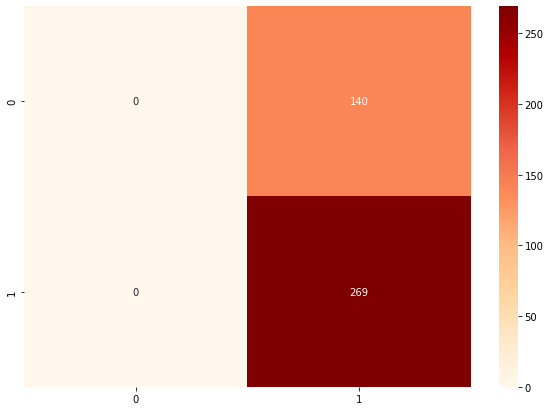

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, ypred)

df_cm = pd.DataFrame(matrix, index = [i for i in "01"],
              columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="OrRd", fmt='g')
plt.show()